In [10]:
%matplotlib inline
# coding=utf-8

import sys
sys.path.extend(['/Users/Dim/Desktop/school_folder/masters_thesis/gitCodeRepo/codePython/collateralOptimizer/'])
from dataPreProcess import *
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt

# Set the path and filename of the historical data to be used
filePath = "/Users/Dim/Desktop/school_folder/masters_thesis/gitCodeRepo/data/"
fileName = "historicalData_fill_20160809.csv"

# Read .csv file, prepare an appropriate subset of the data, calculate variance-covariance matrix
dictData = prepareData(filePath, fileName)
tsData   = fetchDataSubset(dictData['data'], dictData['tfdata'], dictData['date'], lookbackLength = 0)['data']
tsDate   = fetchDataSubset(dictData['data'], dictData['tfdata'], dictData['date'], lookbackLength = 0)['date']
Sigma    = prepareSigma(tsData)

# Align df's to common date based index
tsData = pd.concat([tsData, tsDate], axis=1)
tsData = tsData.set_index('date')

# Adjust "MXHK Index ISIN" index is in HKD, equity is in USD
hkIndex_HKD = pd.to_numeric(tsData['MXHK Index ISIN'])
crcyHKDUSD  = pd.to_numeric(tsData['HKDUSD BGN Curncy ISIN'])

# Apply CCY conversion
hkIndex_USD = np.multiply(hkIndex_HKD, crcyHKDUSD)
hkIndex_USD = hkIndex_USD.rename("MXHK (USD) Index ISIN")
tsData = pd.concat([tsData, hkIndex_USD], axis=1)

# Calculate relative returns R_t = (X_t / X_t-1) - 1 ->> For now use pandas built-in function
# tsDataReturns = tsData.pct_change(1) verified to produce consistent results with above
# returns = (vfiax_monthly.open - vfiax_monthly.open.shift(1))/vfiax_monthly.open
tsReturns = tsData.apply(pd.to_numeric)
tsReturns = tsReturns.pct_change()
tsReturns = tsReturns.dropna(axis=0)

Model 1 - Linear Regression w/ elements of mapping logic and economic intuition

[[ 0.46347841 -0.22599821 -0.07359008  0.44241028]]
0.10501564301
Fitted vs. Actual Plot


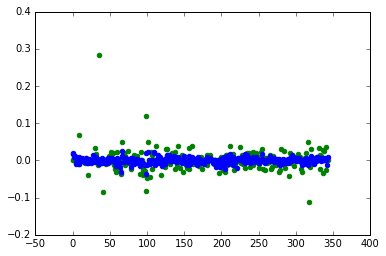

Resid. Plot


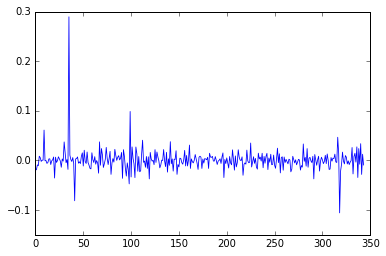

In [24]:
# Regression: Linear Regression - specified based on mapping logic, economic intuition
# Specification y = XB + e
regr = linear_model.LinearRegression(fit_intercept=False)

# Model 1: All indicators, saturated regression
X = ['MXHK (USD) Index ISIN', 'MXAS0IN Index ISIN', 'MMDUAAJ Index ISIN', 'MXASJ Index ISIN']
y = ['KYG217651051 Equity ISIN']
regr.fit(tsReturns[X], tsReturns[y])
tsPredictData = regr.predict(tsReturns[X])

# Evaluate: Model 1
resid = tsReturns[y] - tsPredictData
rSquared = regr.score(tsReturns[X], tsReturns[y])
print regr.coef_
print rSquared

print "Fitted vs. Actual Plot"
plt.scatter(range(0, tsReturns[y].size), tsReturns[y], color="green")
plt.scatter(range(0, tsReturns[y].size), tsPredictData, color='blue')
plt.show()

print "Resid. Plot"
plt.figure()
line, = plt.plot(range(0, tsReturns[y].size), resid, '-', linewidth=.8, color='blue')
plt.show()

Comments:
 
->> It is obvious that some outliers exist, this may be better solved via the Theil-Senn estimator, see below

->> Residuals seem well behaved, R-squared is low

[[ 0.71879188 -0.15290526]]
0.100160539022
Fitted vs. Actual Plot


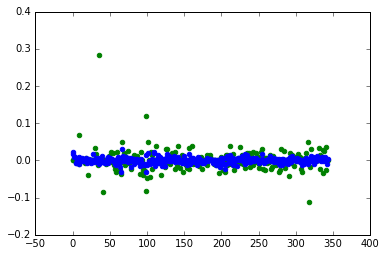

Resid. Plot


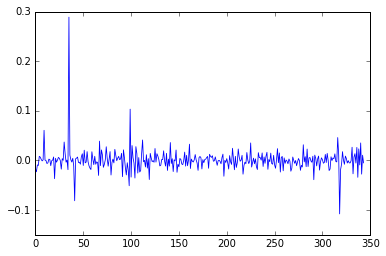

In [23]:
# Model 2: Economic intuition, only selected indicators used 
X = ['MXHK (USD) Index ISIN', 'MXAS0IN Index ISIN']
y = ['KYG217651051 Equity ISIN']
regr.fit(tsReturns[X], tsReturns[y])
tsPredictData = regr.predict(tsReturns[X])

# Evaluate: Model 2
resid = tsReturns[y] - tsPredictData
rSquared = regr.score(tsReturns[X], tsReturns[y])
print regr.coef_
print rSquared

print "Fitted vs. Actual Plot"
plt.scatter(range(0, tsReturns[y].size), tsReturns[y], color="green")
plt.scatter(range(0, tsReturns[y].size), tsPredictData, color='blue')
plt.show()

print "Resid. Plot"
plt.figure()
line, = plt.plot(range(0, tsReturns[y].size), resid, '-', linewidth=.8, color='blue')
plt.show()